In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy import stats

In [2]:
#read the data file into a pandas dataframe
data = pd.read_csv('OJ.txt', sep=",")

#encode the necessary columns and remove Unnamed: 0 (unique ID that is already provided by pandas as well)
data['Store7'] = data['Store7'].astype("category").cat.codes
data = data.drop(columns = ['Unnamed: 0'])

#create the X and Y dataframes
X = data.drop(columns = ['Purchase'])
Y = data['Purchase']

In [3]:
#use train_test_split to split X and Y into training and testing dataframes
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=800, random_state=42)

In [4]:
#print class fractions for training set
Y_train.value_counts()

CH    494
MM    306
Name: Purchase, dtype: int64

In [5]:
#print class fractions for test set
Y_test.value_counts()

CH    159
MM    111
Name: Purchase, dtype: int64

In [6]:
#test linear kernel SVC with C = 0.01 and fit it on the training data
classifier = SVC(C = 0.01, gamma='auto', kernel = 'linear')
classifier.fit(X_train, Y_train) 

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [7]:
header = "Column Header\tCoefficient\n"
header = header.expandtabs(30)
print(header)

for i in range(X_train.columns.size):
    string = str(X_train.columns[i])
    string += str("\t%0.4f" % classifier.coef_[0][i])
    
    if classifier.coef_[0][i] < 0:
        to_print = string.expandtabs(30)
    else:
        to_print = string.expandtabs(31)
    print(to_print)

Column Header                 Coefficient

WeekofPurchase                -0.0099
StoreID                       -0.1276
PriceCH                        0.0489
PriceMM                       -0.0780
DiscCH                         0.0036
DiscMM                         0.1524
SpecialCH                     -0.0628
SpecialMM                      0.1856
LoyalCH                       -1.0212
SalePriceMM                   -0.2304
SalePriceCH                    0.0454
PriceDiff                     -0.2758
Store7                        -0.0145
PctDiscMM                      0.0704
PctDiscCH                      0.0016
ListPriceDiff                 -0.1270
STORE                         -0.0262


In [8]:
#predict X_test and print the Training and Test Accuracy results
classifier.predict(X_test)

print("Linear Kernel Results\n")
print("Training Accuracy Score: %0.4f" % classifier.score(X_train,Y_train))
print("Test Accuracy Score: %0.4f" % classifier.score(X_test,Y_test))

Linear Kernel Results

Training Accuracy Score: 0.7600
Test Accuracy Score: 0.7222


In [9]:
#clear convergence warning where applicable
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

#create a list of 50 C values from 0.01 to 10 and a list to store the accuracy scores
c_vals = np.linspace(0.01,10,50)
cv_accuracy_scores = []

#for each C value being tested use cross_validate for cross validation of the accuracy scores for each C
for c_val in c_vals:
    svm_acc_score = cross_validate(SVC(C = c_val , gamma='auto', kernel = 'linear', max_iter = 10000), X_train, Y_train, cv=10)
    
    cv_accuracy_scores.append(svm_acc_score['test_score'].mean())  

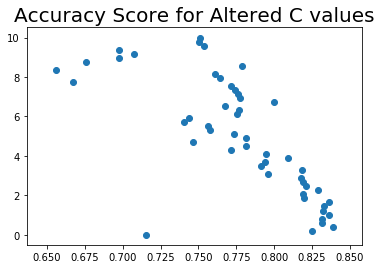

In [10]:
#display the CV error plot
plt.scatter(cv_accuracy_scores,c_vals)
plt.title("Accuracy Score for Altered C values", fontsize = 20)
plt.show()

In [11]:
#idetify the best C value using one-stderr rule 
#use stats.sem to find the stderr val
#find the max accuracy score and identify the values within one stderr of that 

#the optimal C within one stderr of the max is the first C found within that range
#take first, smallest C
#"A lower C will encourage a larger margin, therefore a simpler decision function"
#https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

one_std_err = stats.sem(cv_accuracy_scores)
max_score = np.amax(cv_accuracy_scores)
threshold_score = max_score - one_std_err
std_err_scores = cv_accuracy_scores - one_std_err
c_index = np.argwhere(std_err_scores>=threshold_score)[0][0]
c_val = c_vals[c_index]

In [12]:
#re-fit the training data with new SVC using the optimal C val found within one stderr of best C
classifier = SVC(C = c_val, gamma='auto', kernel = 'linear', max_iter = 10000)
classifier.fit(X_train, Y_train) 

SVC(C=0.41775510204081634, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=10000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
#print the Training and Test Accuracy results
classifier.predict(X_test)

print("Linear Kernel Results With Cross-validated C\n")
print("Best C value from cross-validation: %0.4f" % c_val)
print("Training Accuracy Score: %0.4f" % classifier.score(X_train,Y_train))
print("Test Accuracy Score: %0.4f" % classifier.score(X_test,Y_test))

Linear Kernel Results With Cross-validated C

Best C value from cross-validation: 0.4178
Training Accuracy Score: 0.8363
Test Accuracy Score: 0.8037


In [14]:
#define a function to build a grid of combinations for C values and Gamma values to test 
#based on the number of C and Gamma values passed in as parameters
#return a reshaped list of the grid
def build_grid(c_size, gamma_size):
    c_vals = np.linspace(0.01,10,c_size)
    gamma_vals = np.linspace(0.01,10,gamma_size)

    c_and_gamma_vals = []

    for i in range(c_size):
        for j in range(gamma_size):
            c_and_gamma_vals.append((c_vals[i],gamma_vals[j]))
    
    c_and_gamma_vals = np.array(c_and_gamma_vals)
    c_and_gamma_vals = np.reshape(c_and_gamma_vals,(c_size,gamma_size,2))
    
    return c_and_gamma_vals

In [15]:
#create a grid with c and gamma counts of 30 each and store the returned list
c_size = 30
gamma_size = 30
c_gamma_grid = build_grid(c_size,gamma_size)

In [16]:
#test using a radial kernel and use cross validation on all C value/Gamma value combinations from the grid created above
cv_accuracy_scores_radial = []
for x in c_gamma_grid:
    for y in x:
        svm_acc_score_radial = cross_validate(SVC(C = y[0] , gamma=y[1], kernel = 'rbf', max_iter = 10000), X_train, Y_train, cv=10)
        cv_accuracy_scores_radial.append(svm_acc_score_radial['test_score'].mean())

In [17]:
#reshape the accuracy scores list
cv_accuracy_scores_radial = np.array(cv_accuracy_scores_radial)
cv_accuracy_scores_radial = np.reshape(cv_accuracy_scores_radial,(c_size,gamma_size))

#identify the max score in the list and its location
max_score = np.amax(cv_accuracy_scores_radial)
location = np.argwhere(cv_accuracy_scores_radial>=max_score)[0]

#extract the c index and the gamma index from location
c_index = location[0]
gamma_index = location[1]

#store the optimal combination of c and gamma values
c_val = c_gamma_grid[c_index][gamma_index][0]
gamma_val = c_gamma_grid[c_index][gamma_index][1]

In [18]:
#refit the training data with the SVC with the new found c and gamma values with a radial kernel 
classifier = SVC(C = c_val, gamma=gamma_val, kernel = 'rbf', max_iter = 10000)
classifier.fit(X_train, Y_train) 
classifier.predict(X_test)

#print C and Gamma values, as well as the Training and Test Accuracy results
print("RBF Kernel Results With Cross-validated C and Gamma\n")
print("Best C value from cross-validation: %0.4f" % c_val)
print("Best Gamma value from cross-validation: %0.4f" % gamma_val)
print("Training Accuracy Score: %0.4f" % classifier.score(X_train,Y_train))
print("Test Accuracy Score: %0.4f" % classifier.score(X_test,Y_test))

RBF Kernel Results With Cross-validated C and Gamma

Best C value from cross-validation: 9.6555
Best Gamma value from cross-validation: 0.0100
Training Accuracy Score: 0.8400
Test Accuracy Score: 0.7926


In [19]:
#test using a polynomial kernel and use cross validation on all C value/Gamma value combinations from the grid created above
cv_accuracy_scores_poly = []
for x in c_gamma_grid:
    for y in x:
        svm_acc_score_poly = cross_validate(SVC(C = y[0] , gamma=y[1], kernel = 'poly', max_iter = 10000), X_train, Y_train, cv=10)
        cv_accuracy_scores_poly.append(svm_acc_score_poly['test_score'].mean())

In [20]:
#reshape the accuracy scores list
cv_accuracy_scores_poly = np.array(cv_accuracy_scores_poly)
cv_accuracy_scores_poly = np.reshape(cv_accuracy_scores_poly,(c_size,gamma_size))

#identify the max score in the list and its location
max_score = np.amax(cv_accuracy_scores_poly)
location = np.argwhere(cv_accuracy_scores_poly>=max_score)[0]

#extract the c index and the gamma index from location
c_index = location[0]
gamma_index = location[1]

#store the optimal combination of c and gamma values
c_val = c_gamma_grid[c_index][gamma_index][0]
gamma_val = c_gamma_grid[c_index][gamma_index][1]

In [21]:
#refit the training data with the SVC with the new found c and gamma values with a polynomial kernel 
classifier = SVC(C = c_val, gamma=gamma_val, kernel = 'poly', max_iter = 10000)
classifier.fit(X_train, Y_train) 
classifier.predict(X_test)

#print C and Gamma values, as well as the Training and Test Accuracy results
print("Polynomial Kernel Results With Cross-validated C and Gamma\n")
print("Best C value from cross-validation: %0.4f" % c_val)
print("Best Gamma value from cross-validation: %0.4f" % gamma_val)
print("Training Accuracy Score: %0.4f" % classifier.score(X_train,Y_train))
print("Test Accuracy Score: %0.4f" % classifier.score(X_test,Y_test))

Polynomial Kernel Results With Cross-validated C and Gamma

Best C value from cross-validation: 8.6221
Best Gamma value from cross-validation: 7.2441
Training Accuracy Score: 0.6887
Test Accuracy Score: 0.7000
